# **Pruning and Sparsing**





This colab notebook provides code and a framework for ***Pruning and sparsing***.



# **Setup**

First, install the required packages and download the datasets and pretrained model. Here we use CIFAR10 dataset and VGG network which is the same as what we used in the Lab 0 tutorial.

In [ ]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
All required packages have been successfully installed!


In [ ]:
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys, ssl
    from urllib.request import urlretrieve
    ssl._create_default_https_context = ssl._create_unverified_context
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

we will use CIFAR-10 as our target dataset. This dataset contains images from 10 classes, where each image is of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [ ]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


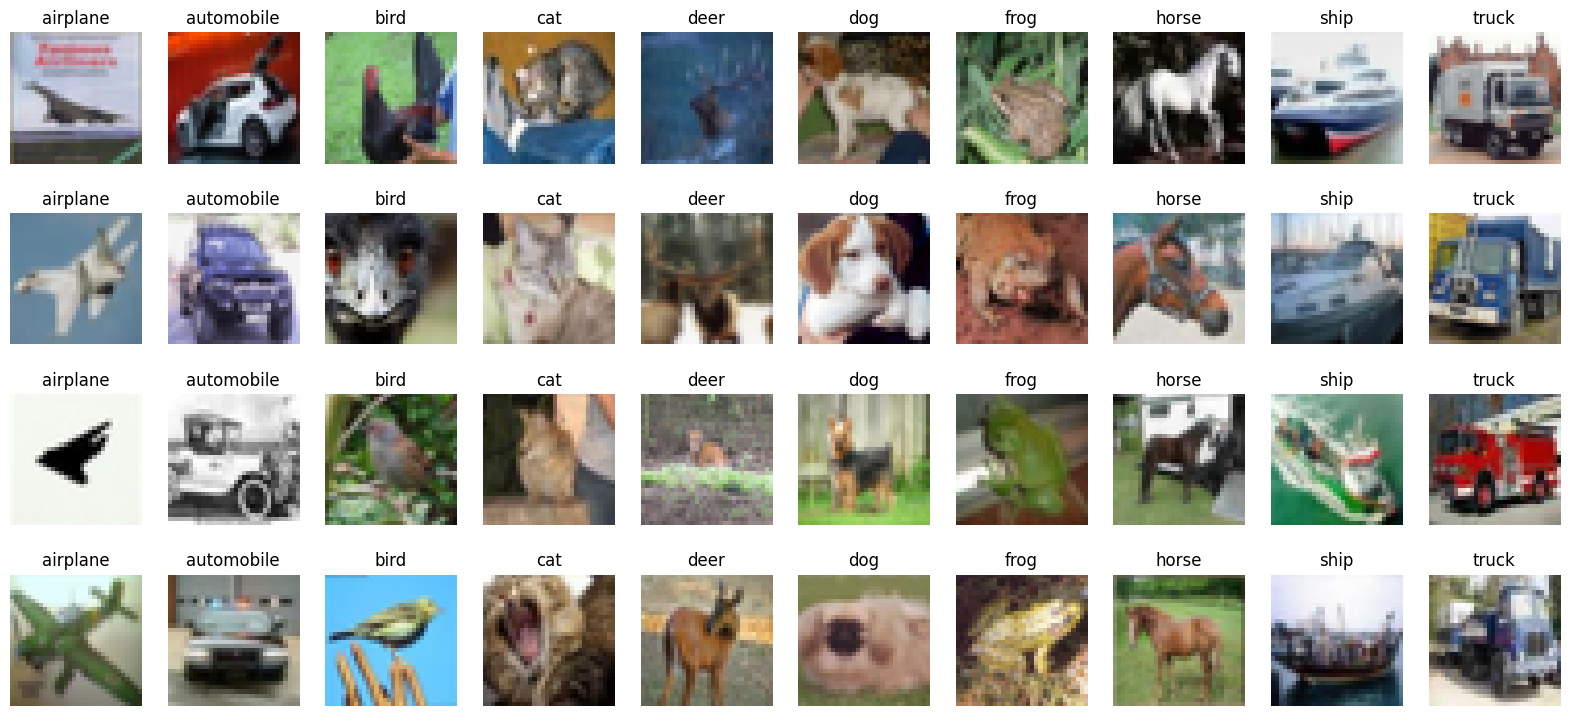

In [ ]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

In [ ]:
for inputs, targets in dataloader["train"]:
  print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
  print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
  break

[inputs] dtype: torch.float32, shape: torch.Size([512, 3, 32, 32])
[targets] dtype: torch.int64, shape: torch.Size([512])


In [ ]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

model = VGG().cuda()

In [ ]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [ ]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Helper Functions (Flops, Model Size calculation, etc.)

---
* The computation cost can be estimated by the number of [multiply–accumulate operations (MACs)](https://en.wikipedia.org/wiki/Multiply–accumulate_operation) using [TorchProfile](https://github.com/zhijian-liu/torchprofile):


In [ ]:

def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

# We can train the model directly


*As* we are working on a classification problem, we will apply [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) as our loss function to optimize the model:

In [ ]:
criterion = nn.CrossEntropyLoss()

Optimization will be carried out using [stochastic gradient descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) with [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum):

In [ ]:
optimizer = SGD(
  model.parameters(),
  lr=0.4,
  momentum=0.9,
  weight_decay=5e-4,
)

The learning rate will be modulated using the following scheduler (which is adapted from [this blog series](https://myrtle.ai/learn/how-to-train-your-resnet/)):

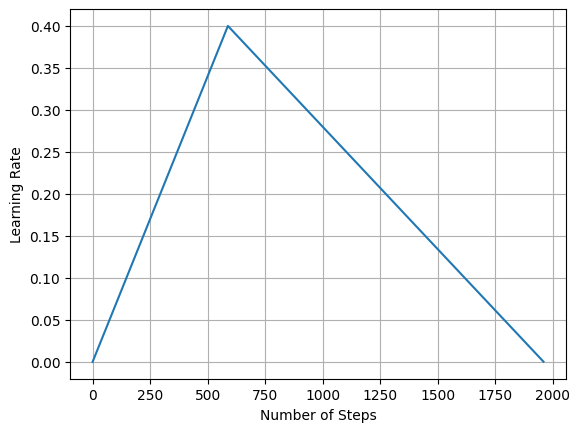

In [ ]:
num_epochs = 20
steps_per_epoch = len(dataloader["train"])

# Define the piecewise linear scheduler
lr_lambda = lambda step: np.interp(
  [step / steps_per_epoch],
  [0, num_epochs * 0.3, num_epochs],
  [0, 1, 0]
)[0]

# Visualize the learning rate schedule
steps = np.arange(steps_per_epoch * num_epochs)
plt.plot(steps, [lr_lambda(step) * 0.4 for step in steps])
plt.xlabel("Number of Steps")
plt.ylabel("Learning Rate")
plt.grid("on")
plt.show()

scheduler = LambdaLR(optimizer, lr_lambda)

With training and evaluation functions, we can finally start training the model! This will take around 10 minutes.

In [ ]:
for epoch_num in tqdm(range(1, num_epochs + 1)):
  train(model, dataloader["train"], criterion, optimizer, scheduler)
  metric = evaluate(model, dataloader["test"])
  print(f"epoch {epoch_num}:", metric)

  0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 1: 20.009998321533203


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 2: 59.20000076293945


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 3: 58.48999786376953


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 4: 68.00999450683594


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 5: 67.27999877929688


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 6: 60.57999801635742


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 7: 73.63999938964844


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 8: 67.55999755859375


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 9: 70.27999877929688


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 10: 74.32999420166016


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 11: 78.77999877929688


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 12: 85.40999603271484


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 13: 80.08999633789062


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 14: 84.83999633789062


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 15: 83.59000396728516


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 16: 87.14999389648438


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 17: 87.75999450683594


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 18: 90.12999725341797


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 19: 91.7699966430664


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 20: 92.40999603271484


Saving the trained model

In [ ]:
PATH="/content/vgg.cifar.pretrained.pth"
torch.save(model.state_dict(), PATH)
cp = torch.load(download_url(PATH), map_location="cpu")
model = VGG().cuda()
recover_model = lambda: model.load_state_dict(cp)
recover_model()
metric = evaluate(model, dataloader["test"])
print(f"epoch {epoch_num}:", metric)

eval:   0%|          | 0/20 [00:00<?, ?it/s]

epoch 20: 92.40999603271484


#OR Optional dowloading

Load the pretrained model and the CIFAR-10 dataset. This part is optional


In [ ]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint)
recover_model = lambda: model.load_state_dict(checkpoint)

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


# Let's First Evaluate the Accuracy and Model Size of Dense Model

Neural networks have become ubiquitous in many applications. Here we have loaded a pretrained VGG model for classifying images in CIFAR10 dataset.

Let's first evaluate the accuracy and model size of this model.

In [ ]:
dense_model_accuracy = evaluate(model, dataloader['test'])
dense_model_size = get_model_size(model)
model_macs=get_model_macs(model, torch.randn(1,3,32,32).to('cuda'))
model_sparsity=get_model_sparsity(model)
num_parameters=get_num_parameters(model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")
print(f"number of macs for the model={model_macs}")
print(f"model parameters={num_parameters}")


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.41%
dense model has size=35.20 MiB
number of macs for the model=606164480
model parameters=9228362


While large neural networks are very powerful, their size consumes considerable storage, memory bandwidth, and computational resources.
As we can see from the results above, a model for the task as simple as classifying $32\times32$ images into 10 classes can be as large as 35 MiB.
For embedded mobile applications, these resource demands become prohibitive.

Therefore, neural network pruning is exploited to facilitates storage and transmission of mobile applications incorporating DNNs.

The goal of pruning is to reduce the model size while maintaining the accuracy.

# Let's see the distribution of weight values

Before we jump into pruning, let's see the distribution of weight values in the dense model.

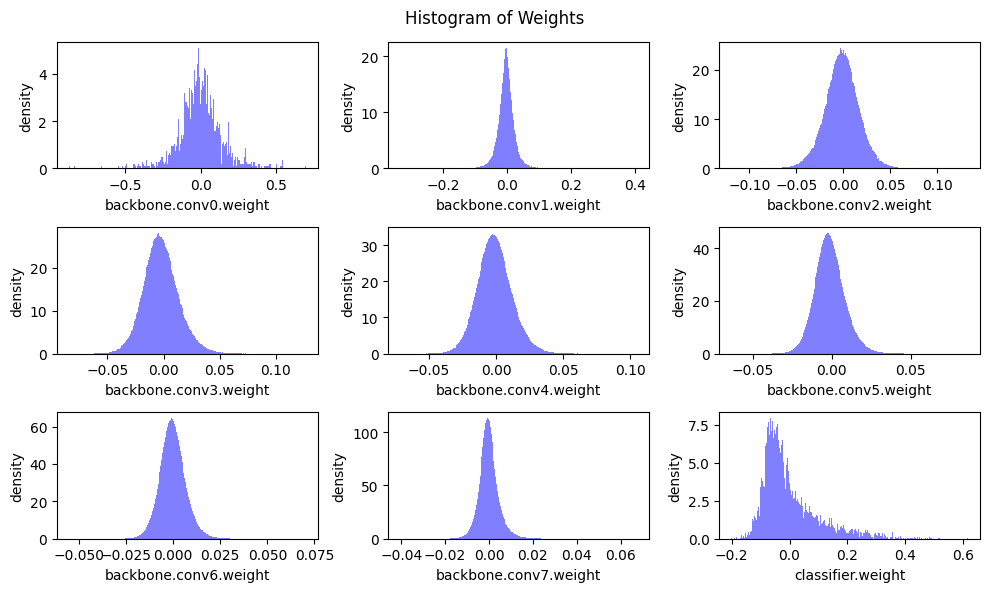

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

# Fine-grained Pruning

Define misc functions for verification.

In [ ]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    #fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

In this section, we will implement and perform fine-grained pruning.

Fine-grained pruning removes the synapses with lowest importance. The weight tensor $W$ will become sparse after fine-grained pruning, which can be described with **sparsity**:

> $\mathrm{sparsity} := \#\mathrm{Zeros} / \#W = 1 - \#\mathrm{Nonzeros} / \#W$

where $\#W$ is the number of elements in $W$.

In practice, given the target sparsity $s$, the weight tensor $W$ is multiplied with a binary mask $M$ to disregard removed weight:

> $v_{\mathrm{thr}} = \texttt{kthvalue}(Importance, \#W \cdot s)$
>
> $M = Importance > v_{\mathrm{thr}}$
>
> $W = W \cdot M$

where $Importance$ is importance tensor with the same shape of $W$, $\texttt{kthvalue}(X, k)$ finds the $k$-th smallest value of tensor $X$, $v_{\mathrm{thr}}$ is the threshold value.

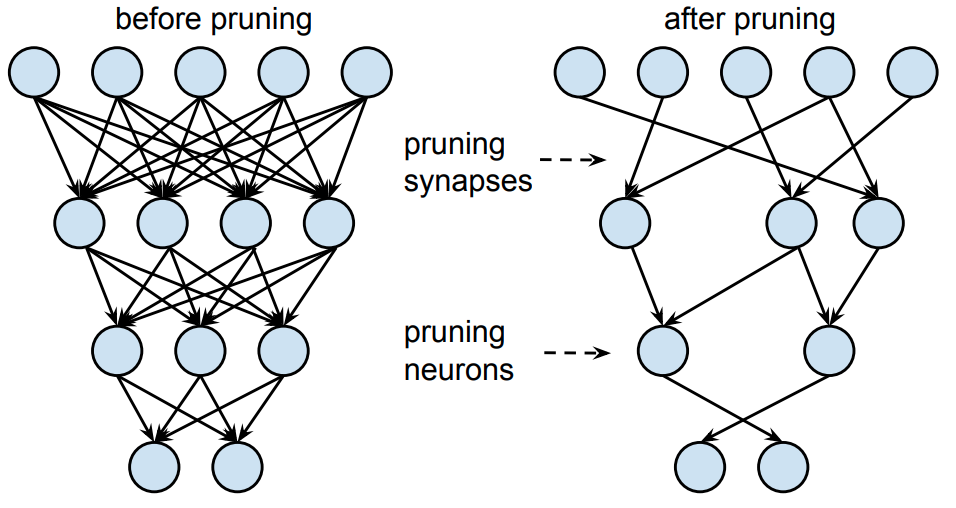

## Magnitude-based Pruning

For fine-grained pruning, a widely-used importance is the magnitude of weight value, *i.e.*,

$Importance=|W|$

This is known as **Magnitude-based Pruning** (see [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf)).

Please complete the following magnitude-based fine-grained pruning function.

**Hint**:
*   In step 1, we calculate the number of zeros (`num_zeros`) after pruning. Note that `num_zeros` should be an integer. You could use either `round()` or `int()` to convert a floating number into an integer. Here we use `round()`.
*   In step 2, we calculate the `importance` of weight tensor. Pytorch provides [`torch.abs()`](https://pytorch.org/docs/stable/generated/torch.abs.html#torch.abs), [`torch.Tensor.abs()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs.html#torch.Tensor.abs), [`torch.Tensor.abs_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.abs_.html) APIs.
*   In step 3, we calculate the pruning `threshold` so that all synapses with importance smaller than `threshold` will be removed. Pytorch provides [`torch.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.kthvalue.html), [`torch.Tensor.kthvalue()`](https://pytorch.org/docs/stable/generated/torch.Tensor.kthvalue.html), [`torch.topk()`](https://pytorch.org/docs/stable/generated/torch.topk.html) APIs.
*   In step 4, we calculate the pruning `mask` based on the `threshold`. **1** in the `mask` indicates the synapse will be kept, and **0** in the `mask` indicates the synapse will be removed. `mask = importance > threshold`. Pytorch provides [`torch.gt()`](https://pytorch.org/docs/stable/generated/torch.gt.html?highlight=torch%20gt#torch.gt) API.

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements*sparsity)
    print(num_zeros)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    print(importance)
    # Step 3: calculate the pruning threshold
    threshold,ind=  torch.kthvalue(torch.abs(tensor.view(-1)), num_zeros)
    print(threshold)
    # Step 4: calculate the pruning mask
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance.gt(threshold)
    print(mask)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

Let's verify the functionality of defined fine-grained pruning by applying the function above on a dummy tensor.

### Test pruning fuction





The last cell plots the tensor before and after pruning. Nonzeros are rendered in blue while zeros are rendered in gray. Please modify the value of `target_sparsity` in the following code cell so that there are only 10 nonzeros in the sparse tensor after pruning.

19
tensor([[0.4600, 0.4000, 0.3900, 0.1900, 0.3700],
        [0.0000, 0.4000, 0.1700, 0.1500, 0.1600],
        [0.2000, 0.2300, 0.3600, 0.2500, 0.0300],
        [0.2400, 0.4100, 0.0700, 0.1300, 0.1500],
        [0.4800, 0.0900, 0.3600, 0.1200, 0.4500]])
tensor(0.3900)
tensor([[ True,  True, False, False, False],
        [False,  True, False, False, False],
        [False, False, False, False, False],
        [False,  True, False, False, False],
        [ True, False, False, False,  True]])


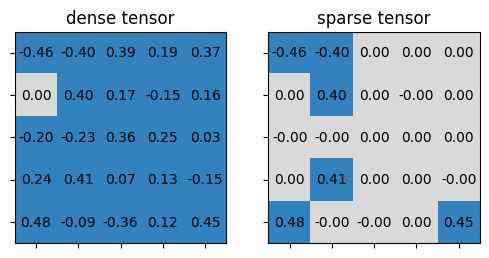

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [ ]:
##################### YOUR CODE STARTS HERE #####################
target_sparsity = .75 # please modify the value of target_sparsity
##################### YOUR CODE ENDS HERE #####################
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=6)

We now wrap the fine-grained pruning function into a class for pruning the whole model. In class `FineGrainedPruner`, we have to keep a record of the pruning masks so that we could apply the masks whenever the model weights change to make sure the model keep sparse all the time.

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

## Sensitivity Scan


Different layers contribute differently to the model performance. It is challenging to decide the proper sparsity for each layer. A widely used approach is sensitivity scan.

During the sensitivity scan, at each time, we will only prune one layer to see the accuracy degradation. By scanning different sparsities, we could draw the sensitivity curve (i.e., accuracy vs. sparsity) of the corresponding layer.

Here is an example figure for sensitivity curves. The x-axis is the sparsity or the percentage of #parameters dropped (*i.e.*, sparsity). The y-axis is the validation accuracy. (This is Figure 6 in [Learning both Weights and Connections for Efficient
Neural Networks](https://arxiv.org/pdf/1506.02626.pdf))


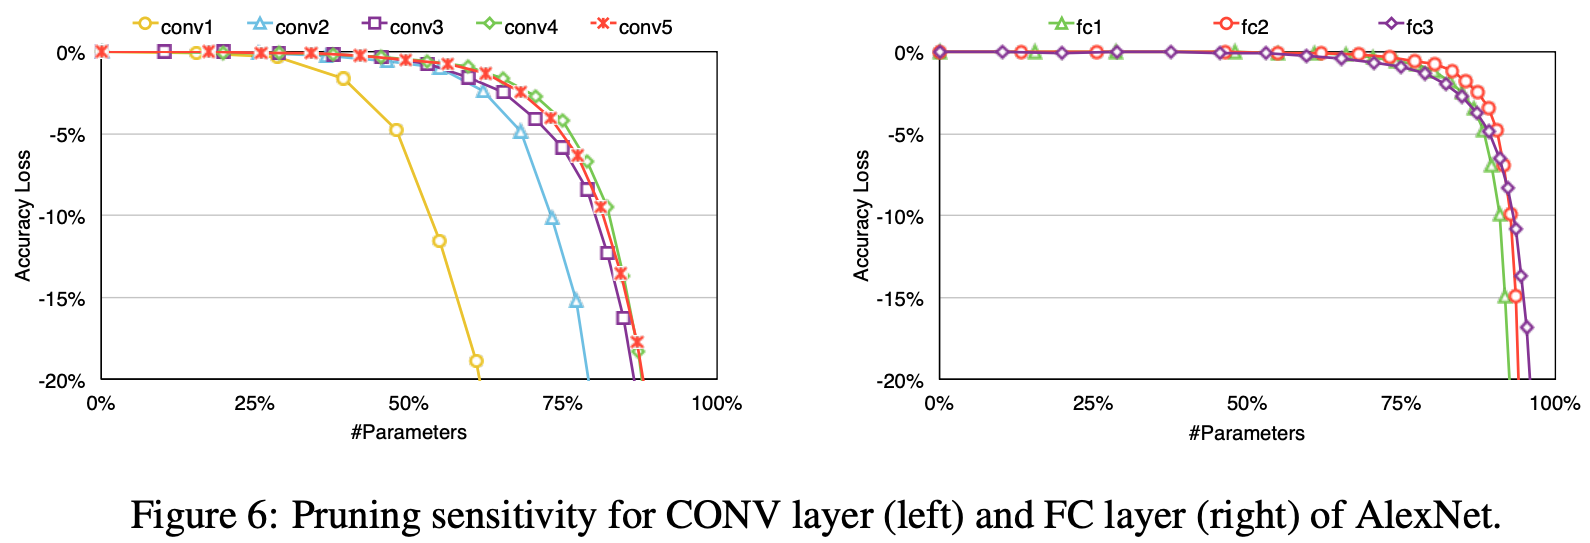

The following code cell defines the sensitivity scan function that returns the sparsities scanned, and a list of accuracies for each weight to be pruned.

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

Please run the following cells to plot the sensitivity curves. It should take around 2 minutes to finish.

In [ ]:
sparsities, accuracies = sensitivity_scan(
    model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/9 weight - backbone.conv0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

691
tensor([[[[1.8584e-01, 2.1532e-01, 3.0006e-01],
          [4.3097e-01, 2.5755e-01, 1.4840e-01],
          [1.5115e-01, 4.9175e-01, 1.0716e-01]],

         [[3.3234e-03, 1.6032e-01, 6.1027e-02],
          [5.3925e-01, 2.2659e-01, 2.4288e-01],
          [2.3063e-01, 1.0323e-01, 6.0609e-02]],

         [[3.0993e-01, 2.5345e-01, 2.2280e-02],
          [3.1153e-01, 1.5683e-01, 5.4615e-02],
          [1.9360e-01, 6.3481e-02, 2.6940e-01]]],


        [[[7.5536e-02, 5.9120e-02, 3.0514e-01],
          [2.2615e-01, 1.5534e-01, 4.0654e-01],
          [1.9824e-01, 6.9214e-02, 1.1612e-01]],

         [[2.4910e-02, 1.9284e-01, 3.1851e-02],
          [2.3415e-03, 1.4714e-01, 1.5469e-01],
          [1.3667e-02, 3.9957e-02, 6.0505e-02]],

         [[9.3160e-02, 1.5024e-01, 9.4484e-02],
          [1.5307e-01, 8.5005e-02, 3.0885e-02],
          [1.0851e-01, 4.5618e-02, 4.3801e-02]]],


        [[[1.9714e-01, 3.0942e-02, 1.1984e-01],
          [2.9102e-02, 1.8369e-01, 1.1993e-01],
          [2.7197e-0

scanning 1/9 weight - backbone.conv1.weight:   0%|          | 0/6 [00:00<?, ?it/s]

29491
tensor([[[[6.5957e-02, 3.9557e-02, 1.9778e-02],
          [7.4201e-02, 1.1751e-02, 2.5742e-03],
          [6.7291e-02, 1.0731e-02, 1.2106e-02]],

         [[1.8259e-02, 1.3740e-02, 3.5242e-03],
          [6.8186e-03, 2.4171e-02, 2.2237e-02],
          [2.9423e-04, 1.0280e-02, 9.3871e-03]],

         [[1.0131e-02, 3.0248e-02, 1.8600e-02],
          [8.6461e-03, 2.8432e-02, 7.2304e-03],
          [1.4638e-02, 3.6953e-03, 1.2418e-02]],

         ...,

         [[5.0095e-02, 5.6595e-02, 4.5579e-02],
          [4.4211e-02, 4.7623e-02, 4.6174e-02],
          [1.6058e-02, 2.3759e-02, 2.6225e-02]],

         [[3.0077e-03, 1.8823e-02, 1.5786e-03],
          [2.5959e-03, 1.8260e-02, 5.8382e-03],
          [4.4440e-03, 2.5559e-02, 7.1761e-03]],

         [[2.0155e-02, 4.2815e-03, 7.8006e-03],
          [1.8327e-02, 1.4742e-02, 1.7075e-02],
          [3.5020e-03, 2.8682e-03, 1.0296e-02]]],


        [[[2.3840e-02, 4.1567e-02, 1.9364e-02],
          [2.5850e-02, 1.1027e-04, 1.8596e-02],
     

scanning 2/9 weight - backbone.conv2.weight:   0%|          | 0/6 [00:00<?, ?it/s]

117965
tensor([[[[0.0183, 0.0137, 0.0596],
          [0.0330, 0.0011, 0.0434],
          [0.0278, 0.0040, 0.0365]],

         [[0.0273, 0.0227, 0.0165],
          [0.0158, 0.0030, 0.0123],
          [0.0232, 0.0057, 0.0040]],

         [[0.0125, 0.0074, 0.0203],
          [0.0459, 0.0434, 0.0237],
          [0.0133, 0.0122, 0.0033]],

         ...,

         [[0.0177, 0.0054, 0.0031],
          [0.0156, 0.0189, 0.0038],
          [0.0001, 0.0091, 0.0004]],

         [[0.0186, 0.0215, 0.0075],
          [0.0047, 0.0105, 0.0045],
          [0.0056, 0.0017, 0.0068]],

         [[0.0233, 0.0040, 0.0089],
          [0.0339, 0.0206, 0.0025],
          [0.0190, 0.0153, 0.0014]]],


        [[[0.0077, 0.0133, 0.0105],
          [0.0091, 0.0012, 0.0059],
          [0.0129, 0.0088, 0.0117]],

         [[0.0003, 0.0021, 0.0052],
          [0.0039, 0.0193, 0.0015],
          [0.0027, 0.0068, 0.0247]],

         [[0.0016, 0.0055, 0.0072],
          [0.0096, 0.0169, 0.0066],
          [0.0040, 0.012

scanning 3/9 weight - backbone.conv3.weight:   0%|          | 0/6 [00:00<?, ?it/s]

235930
tensor([[[[2.0010e-02, 6.6335e-03, 1.7664e-02],
          [1.4175e-02, 4.6843e-03, 4.2273e-04],
          [4.2034e-03, 1.5645e-02, 2.9023e-02]],

         [[3.1925e-03, 7.2937e-03, 1.5763e-02],
          [6.9925e-03, 5.1170e-03, 2.1656e-03],
          [2.0131e-02, 1.7104e-02, 3.1696e-03]],

         [[3.1379e-02, 1.3577e-02, 7.7614e-03],
          [1.5473e-02, 2.6310e-04, 1.0663e-02],
          [1.3075e-03, 4.2183e-03, 6.1464e-03]],

         ...,

         [[2.1863e-02, 1.4728e-02, 7.2738e-03],
          [4.4823e-02, 1.2170e-02, 7.6838e-03],
          [3.3777e-03, 1.8065e-02, 1.9851e-02]],

         [[6.4967e-03, 3.9441e-03, 2.3323e-02],
          [2.2321e-02, 2.8328e-02, 9.2862e-03],
          [1.9111e-02, 6.7935e-03, 3.9028e-03]],

         [[8.6882e-03, 1.4712e-02, 7.4471e-03],
          [5.0692e-03, 1.9064e-02, 2.1197e-02],
          [1.3416e-02, 3.1293e-02, 2.5503e-02]]],


        [[[1.6034e-03, 7.3097e-03, 2.5482e-02],
          [1.0053e-02, 2.1183e-02, 1.1742e-02],
    

scanning 4/9 weight - backbone.conv4.weight:   0%|          | 0/6 [00:00<?, ?it/s]

471859
tensor([[[[0.0085, 0.0216, 0.0058],
          [0.0176, 0.0036, 0.0099],
          [0.0150, 0.0187, 0.0054]],

         [[0.0132, 0.0026, 0.0212],
          [0.0008, 0.0029, 0.0061],
          [0.0010, 0.0120, 0.0049]],

         [[0.0033, 0.0018, 0.0010],
          [0.0051, 0.0173, 0.0011],
          [0.0091, 0.0139, 0.0180]],

         ...,

         [[0.0137, 0.0130, 0.0113],
          [0.0132, 0.0189, 0.0247],
          [0.0022, 0.0096, 0.0030]],

         [[0.0101, 0.0061, 0.0070],
          [0.0015, 0.0166, 0.0198],
          [0.0083, 0.0187, 0.0202]],

         [[0.0013, 0.0056, 0.0076],
          [0.0086, 0.0151, 0.0145],
          [0.0034, 0.0047, 0.0207]]],


        [[[0.0043, 0.0177, 0.0093],
          [0.0055, 0.0029, 0.0038],
          [0.0158, 0.0071, 0.0036]],

         [[0.0009, 0.0030, 0.0036],
          [0.0042, 0.0143, 0.0035],
          [0.0197, 0.0033, 0.0073]],

         [[0.0125, 0.0103, 0.0028],
          [0.0002, 0.0219, 0.0223],
          [0.0208, 0.000

scanning 5/9 weight - backbone.conv5.weight:   0%|          | 0/6 [00:00<?, ?it/s]

943718
tensor([[[[1.1874e-02, 3.7006e-03, 4.9045e-03],
          [9.2808e-03, 9.9486e-03, 4.4660e-03],
          [7.3962e-03, 1.6542e-03, 4.8769e-03]],

         [[1.4299e-02, 7.8502e-03, 7.0180e-03],
          [1.3101e-02, 3.2778e-03, 6.1646e-03],
          [6.7102e-03, 8.3711e-04, 1.1758e-02]],

         [[7.7314e-03, 1.4056e-03, 4.1106e-03],
          [2.3486e-03, 2.4390e-03, 3.3618e-03],
          [2.8138e-03, 7.0829e-03, 7.7049e-03]],

         ...,

         [[7.9158e-03, 1.7247e-03, 7.1498e-03],
          [3.9118e-03, 1.6705e-03, 5.7285e-03],
          [2.9894e-07, 1.0028e-02, 2.4665e-02]],

         [[1.9672e-03, 8.1841e-03, 1.1358e-02],
          [4.9852e-04, 3.2660e-03, 7.0037e-03],
          [1.2099e-02, 2.7540e-04, 2.6220e-03]],

         [[3.4254e-03, 4.0355e-03, 2.3590e-03],
          [9.5101e-04, 5.4160e-03, 4.8951e-03],
          [3.6362e-05, 5.5751e-03, 2.2277e-03]]],


        [[[1.2703e-02, 6.7917e-03, 4.5188e-04],
          [3.7497e-03, 6.2270e-04, 2.0406e-02],
    

scanning 6/9 weight - backbone.conv6.weight:   0%|          | 0/6 [00:00<?, ?it/s]

943718
tensor([[[[4.5537e-04, 2.9786e-03, 1.8068e-03],
          [3.3000e-04, 4.8902e-03, 1.9160e-03],
          [3.1324e-03, 7.9085e-03, 4.9694e-05]],

         [[4.5765e-03, 4.1758e-03, 6.5161e-03],
          [2.5293e-03, 3.1338e-05, 1.2834e-03],
          [4.6190e-03, 4.7680e-03, 5.7492e-03]],

         [[1.6326e-02, 1.4471e-02, 1.5245e-02],
          [2.0805e-03, 7.6924e-03, 9.9955e-03],
          [1.6501e-03, 8.2974e-03, 1.2391e-03]],

         ...,

         [[1.6553e-03, 3.4763e-05, 5.9477e-03],
          [1.6269e-03, 1.7146e-03, 3.9131e-03],
          [3.1923e-03, 3.4279e-03, 5.3322e-03]],

         [[1.7931e-03, 2.4384e-03, 8.6678e-04],
          [2.2558e-03, 1.3648e-02, 1.1645e-02],
          [2.3025e-03, 6.9367e-03, 7.9424e-03]],

         [[7.4067e-03, 6.3331e-03, 5.6291e-04],
          [4.4964e-03, 1.6674e-03, 1.8745e-03],
          [5.4161e-03, 4.0513e-04, 1.0622e-03]]],


        [[[2.9060e-03, 2.3740e-03, 1.3412e-03],
          [3.6052e-05, 1.2388e-03, 4.4132e-04],
    

scanning 7/9 weight - backbone.conv7.weight:   0%|          | 0/6 [00:00<?, ?it/s]

943718
tensor([[[[5.6591e-03, 2.5932e-03, 4.1294e-03],
          [2.5600e-04, 3.8486e-03, 1.4215e-03],
          [6.6265e-03, 4.3698e-03, 5.9345e-04]],

         [[1.5813e-03, 4.1006e-03, 1.3540e-03],
          [2.0674e-03, 1.3714e-03, 1.6674e-03],
          [3.2445e-03, 3.4886e-03, 9.9422e-04]],

         [[4.8017e-03, 3.5674e-03, 1.0588e-03],
          [1.3266e-03, 1.8185e-03, 2.3685e-03],
          [3.5786e-03, 2.2703e-04, 3.4273e-03]],

         ...,

         [[1.0859e-02, 9.1396e-03, 3.7852e-03],
          [4.7589e-04, 3.2622e-03, 2.3612e-03],
          [1.0745e-03, 1.2822e-03, 7.9211e-04]],

         [[1.1450e-04, 3.3315e-04, 9.6081e-04],
          [7.7430e-05, 1.3879e-03, 2.4822e-03],
          [1.8443e-04, 1.0227e-03, 1.2107e-03]],

         [[3.5512e-04, 1.5744e-03, 2.6526e-03],
          [1.8726e-03, 4.1441e-03, 1.2982e-03],
          [3.1283e-03, 2.6675e-03, 2.7848e-03]]],


        [[[4.0505e-03, 1.7102e-03, 4.0317e-03],
          [1.7819e-03, 1.3441e-03, 3.0184e-03],
    

scanning 8/9 weight - classifier.weight:   0%|          | 0/6 [00:00<?, ?it/s]

2048
tensor([[0.0433, 0.0880, 0.0207,  ..., 0.1597, 0.1034, 0.0082],
        [0.0073, 0.0636, 0.0229,  ..., 0.0199, 0.0568, 0.1257],
        [0.0020, 0.2118, 0.0692,  ..., 0.0656, 0.0961, 0.0967],
        ...,
        [0.0113, 0.0607, 0.0236,  ..., 0.0656, 0.0088, 0.0095],
        [0.0259, 0.0027, 0.1002,  ..., 0.0281, 0.0163, 0.0967],
        [0.2942, 0.0637, 0.1009,  ..., 0.0181, 0.0742, 0.2352]],
       device='cuda:0')
tensor(0.0480, device='cuda:0')
tensor([[False,  True, False,  ...,  True,  True, False],
        [False,  True, False,  ..., False,  True,  True],
        [False,  True,  True,  ...,  True,  True,  True],
        ...,
        [False,  True, False,  ...,  True, False, False],
        [False, False,  True,  ..., False, False,  True],
        [ True,  True,  True,  ..., False,  True,  True]], device='cuda:0')
    sparsity=0.40: accuracy=92.38%2560
tensor([[0.0433, 0.0880, 0.0207,  ..., 0.1597, 0.1034, 0.0082],
        [0.0073, 0.0636, 0.0229,  ..., 0.0199, 0.0568, 0.12

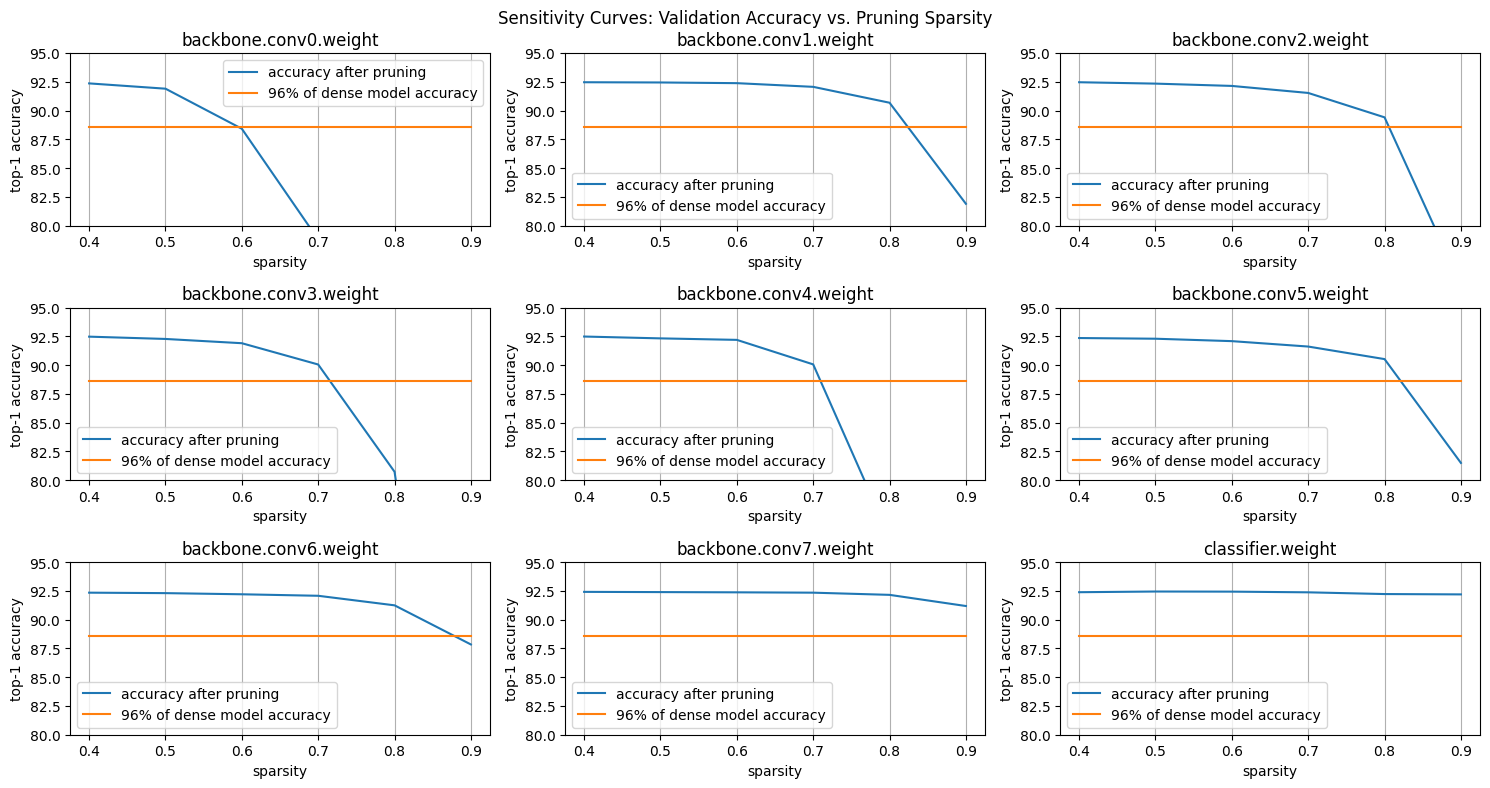

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(15,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

#### Important points

* The relationship between pruning sparsity and model accuracy (*i.e.*, does accuracy increase or decrease when sparsity becomes higher?)

* All the layers does not have the same sensitivity

* Layer with less parameters is the most sensitive to the pruning sparsity

* In addition to accuracy, the number of each layer's parameters also affects the decision on sparsity selection. Layers with more #parameters require larger sparsities.

Please run the following code cell to plot the distribution of #parameters in the whole model.

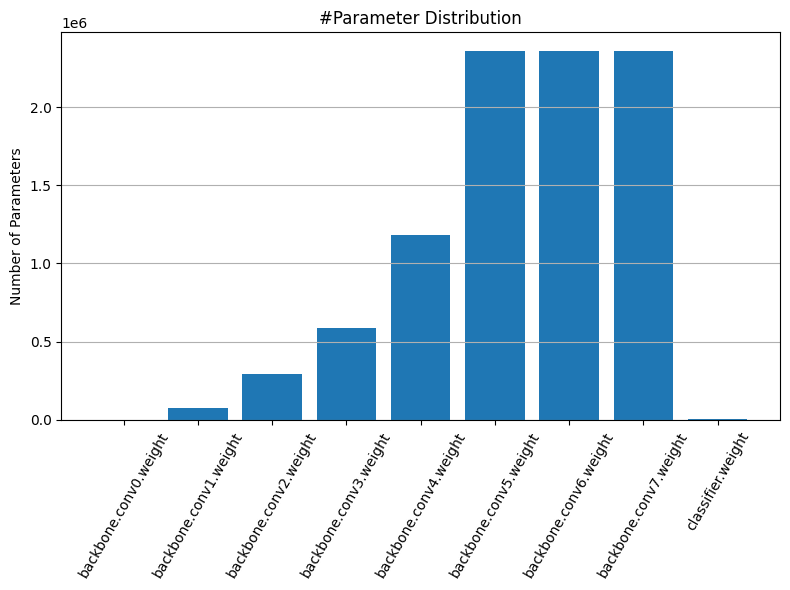

In [ ]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(8, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

## Select Sparsity Based on Sensitivity Curves and \#Parameters Distribution





Based on the sensitivity curves and the distribution of #parameters in the model, please select the sparsity for each layer.

Note that the overall compression ratio of pruned model mostly depends on the layers with larger #parameters, and different layers have different sensitivity to pruning (see Question 4).

Please make sure that after pruning, the sparse model is 25% of the size of the dense model, and validation accuracy is higher than 92.5 after finetuning.
:
*   The layer with more #parameters should have larger sparsity. (see *Figure #Parameter Distribution*)
*   The layer that is sensitive to the pruning sparsity (i.e., the accuracy will drop quickly as sparsity becomes higher) should have smaller sparsity. (see *Figure Sensitivity Curves*)

In [ ]:
evaluate(model, dataloader["test"])

eval:   0%|          | 0/20 [00:00<?, ?it/s]

92.40999603271484

In [ ]:
recover_model()

sparsity_dict = {
##################### YOUR CODE STARTS HERE #####################
    # please modify the sparsity value of each layer
    # please DO NOT modify the key of sparsity_dict
    'backbone.conv0.weight': 0.68,
    'backbone.conv1.weight': 0.81,
    'backbone.conv2.weight': 0.83,
    'backbone.conv3.weight': 0.72,
    'backbone.conv4.weight': 0.75,
    'backbone.conv5.weight': 0.83,
    'backbone.conv6.weight': 0.84,
    'backbone.conv7.weight': 0.90,
    'classifier.weight': 0.95
##################### YOUR CODE ENDS HERE #######################
}

Please run the following cell to prune the model according to your defined `sparsity_dict`, and print the information of sparse model.

1175
tensor([[[[1.8584e-01, 2.1532e-01, 3.0006e-01],
          [4.3097e-01, 2.5755e-01, 1.4840e-01],
          [1.5115e-01, 4.9175e-01, 1.0716e-01]],

         [[3.3234e-03, 1.6032e-01, 6.1027e-02],
          [5.3925e-01, 2.2659e-01, 2.4288e-01],
          [2.3063e-01, 1.0323e-01, 6.0609e-02]],

         [[3.0993e-01, 2.5345e-01, 2.2280e-02],
          [3.1153e-01, 1.5683e-01, 5.4615e-02],
          [1.9360e-01, 6.3481e-02, 2.6940e-01]]],


        [[[7.5536e-02, 5.9120e-02, 3.0514e-01],
          [2.2615e-01, 1.5534e-01, 4.0654e-01],
          [1.9824e-01, 6.9214e-02, 1.1612e-01]],

         [[2.4910e-02, 1.9284e-01, 3.1851e-02],
          [2.3415e-03, 1.4714e-01, 1.5469e-01],
          [1.3667e-02, 3.9957e-02, 6.0505e-02]],

         [[9.3160e-02, 1.5024e-01, 9.4484e-02],
          [1.5307e-01, 8.5005e-02, 3.0885e-02],
          [1.0851e-01, 4.5618e-02, 4.3801e-02]]],


        [[[1.9714e-01, 3.0942e-02, 1.1984e-01],
          [2.9102e-02, 1.8369e-01, 1.1993e-01],
          [2.7197e-

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=50.94% before fintuning


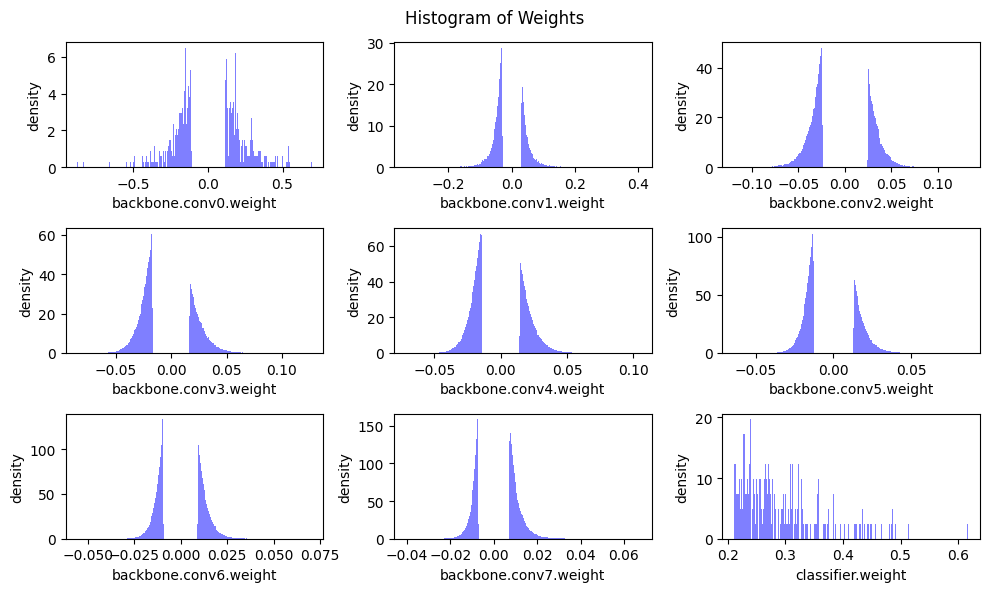

In [ ]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)

## Finetune the fine-grained pruned model

As we can see from the outputs of previous cell, even though fine-grained pruning reduces the most of model weights, the accuracy of model also dropped. Therefore, we have to finetune the sparse model to recover the accuracy.

Please run the following cell to finetune the sparse model. It should take around 3 minutes to finish.

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

Finetuning Fine-grained Pruned Sparse Model


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 1 Accuracy 91.71% / Best Accuracy: 91.71%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 2 Accuracy 92.11% / Best Accuracy: 92.11%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 3 Accuracy 92.16% / Best Accuracy: 92.16%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 4 Accuracy 92.32% / Best Accuracy: 92.32%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

    Epoch 5 Accuracy 92.30% / Best Accuracy: 92.32%


Run the following cell to see the information of best finetuned sparse model.

In [ ]:
# load the best sparse model checkpoint to evaluate the final performance
model.load_state_dict(best_sparse_model_checkpoint['state_dict'])
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'])
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

Sparse model has size=5.89 MiB = 16.74% of dense model size


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Sparse model has accuracy=92.32% after fintuning


# Channel Pruning

In this section, we will implement the channel pruning. Channel pruning removes an entire channel, so that it can achieve inference speed up on existing hardware like GPUs. Similarly, we remove the channels whose weights are of smaller magnitudes (measured by Frobenius norm).

In [ ]:
# firstly, let's restore the model weights to the original dense version
#   and check the validation accuracy
recover_model()
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.41%


## Remove Channel Weights

Unlike fine-grained pruning, we can remove the weights entirely from the tensor in channel pruning. That is to say, the number of output channels is reduced:

> $\#\mathrm{out\_channels}_{\mathrm{new}} = \#\mathrm{out\_channels}_{\mathrm{origin}} \cdot (1 - \mathrm{sparsity})$

The weight tensor $W$ is still dense after channel pruning. Thus, we will refer to *sparsity* as ***prune ratio***.

Like fine-grained pruning, we can use different pruning rates for different layers. However, we use a uniform pruning rate for all the layers for now. We are targeting 2x computation reduction, which is roughly 30% uniform pruning rate (think about why).

Feel free to try out different pruning ratios per layer at the end of this section. You can pass in a list of ratios to the `channel_prune` function.


Here we naively prune all output channels other than the first $\#\mathrm{out\_channels}_{\mathrm{new}}$ channels.

In [ ]:
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """A function to calculate the number of layers to PRESERVE after pruning
    Note that preserve_rate = 1. - prune_ratio
    """
    ##################### YOUR CODE STARTS HERE #####################
    return round(channels*(1-prune_ratio))
    ##################### YOUR CODE ENDS HERE #####################

@torch.no_grad()
def channel_prune(model: nn.Module,
                  prune_ratio: Union[List, float]) -> nn.Module:
    """Apply channel pruning to each of the conv layer in the backbone
    Note that for prune_ratio, we can either provide a floating-point number,
    indicating that we use a uniform pruning rate for all layers, or a list of
    numbers to indicate per-layer pruning rate.
    """
    # sanity check of provided prune_ratio
    assert isinstance(prune_ratio, (float, list))
    n_conv = len([m for m in model.backbone if isinstance(m, nn.Conv2d)])
    # note that for the ratios, it affects the previous conv output and next
    # conv input, i.e., conv0 - ratio0 - conv1 - ratio1-...
    if isinstance(prune_ratio, list):
        assert len(prune_ratio) == n_conv - 1
    else:  # convert float to list
        prune_ratio = [prune_ratio] * (n_conv - 1)

    # we prune the convs in the backbone with a uniform ratio
    model = copy.deepcopy(model)  # prevent overwrite
    # we only apply pruning to the backbone features
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # apply pruning. we naively keep the first k channels
    assert len(all_convs) == len(all_bns)
    for i_ratio, p_ratio in enumerate(prune_ratio):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        original_channels = prev_conv.out_channels  # same as next_conv.in_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)

        # prune the output of the previous conv and bn
        prev_conv.weight.set_(prev_conv.weight.detach()[:n_keep])
        prev_bn.weight.set_(prev_bn.weight.detach()[:n_keep])
        prev_bn.bias.set_(prev_bn.bias.detach()[:n_keep])
        prev_bn.running_mean.set_(prev_bn.running_mean.detach()[:n_keep])
        prev_bn.running_var.set_(prev_bn.running_var.detach()[:n_keep])

        # prune the input of the next conv (hint: just one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.set_(next_conv.weight.detach()[:,:n_keep])
 #       next_conv.in_channels=n_keep
 #       prev_conv.out_channels=n_keep
        ##################### YOUR CODE ENDS HERE #####################

    return model


Run the following cell to perform a sanity check to make sure the implementation is correct.

In [ ]:
dummy_input = torch.randn(1, 3, 32, 32).cuda()
pruned_model = channel_prune(model, prune_ratio=0.3)
pruned_macs = get_model_macs(pruned_model, dummy_input)
macs = get_model_macs(model, dummy_input)
# for name, param in pruned_model.named_parameters():
#   print(name+str(param.shape))
# print(model.backbone)
# print(macs)
# print(305388064-pruned_macs)
assert pruned_macs == 305388064
print('* Check passed. Right MACs for the pruned model.')

* Check passed. Right MACs for the pruned model.


Now let's evaluate the performance of the model after uniform channel pruning with 30% pruning rate.

As you may see, directly removing 30% of the channels leads to low accuracy.

In [ ]:
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=21.61%


## Ranking Channels by Importance

As you can see, removing the first 30% of channels in all layers leads to significant accuracy reduction. One potential method to remedy the issue is to find the **less important** channel weights to remove. A popular criterion for importance is to use the Frobenius norm of the weights corresponding to each input channel:

> $importance_{i} = \|W_{i}\|_2, \;\; i = 0, 1, 2,\cdots, \#\mathrm{in\_channels}-1$

We can sort the channel weights from more important to less important, and then keep the frst $k$ channels for each layer.

### Question 7 (15 pts)
Please complete the following functions for sorting the weight tensor based on the Frobenius norm.

**Hint**:
* To calculate Frobenius norm of a tensor, Pytorch provides [`torch.norm`](https://pytorch.org/docs/master/generated/torch.norm.html?highlight=torch+norm#torch.norm) APIs.

In [ ]:
a=torch.Tensor([3,-4,12])
print(torch.linalg.norm(a))

tensor(13.)


In [ ]:
# function to sort the channels from important to non-important
def get_input_channel_importance(weight):
    in_channels = weight.shape[1]
    importances = []
    # compute the importance for each input channel
    for i_c in range(weight.shape[1]):
        channel_weight = weight.detach()[:, i_c]
        ##################### YOUR CODE STARTS HERE #####################
        importance = torch.linalg.norm(channel_weight)
        ##################### YOUR CODE ENDS HERE #####################
        importances.append(importance.view(1))
    return torch.cat(importances)

@torch.no_grad()
def apply_channel_sorting(model):
    model = copy.deepcopy(model)  # do not modify the original model
    # fetch all the conv and bn layers from the backbone
    all_convs = [m for m in model.backbone if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.backbone if isinstance(m, nn.BatchNorm2d)]
    # iterate through conv layers
    for i_conv in range(len(all_convs) - 1):
        # each channel sorting index, we need to apply it to:
        # - the output dimension of the previous conv
        # - the previous BN layer
        # - the input dimension of the next conv (we compute importance here)
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        # note that we always compute the importance according to input channels
        importance = get_input_channel_importance(next_conv.weight)
        # sorting from large to small
        sort_idx = torch.argsort(importance, descending=True)

        # apply to previous conv and its following bn
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx))
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx)
            )

        # apply to the next conv input (hint: one line of code)
        ##################### YOUR CODE STARTS HERE #####################
        next_conv.weight.copy_(torch.index_select(
            next_conv.weight.detach(), 1, sort_idx))
        ##################### YOUR CODE ENDS HERE #####################

    return model

Now run the following cell to sanity check if the results are correct.

In [ ]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'])
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'])
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

Before sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

dense model has accuracy=92.41%
After sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

sorted model has accuracy=92.41%
* Check passed.


Finally, we compare the pruned models' accuracy with and without sorting.

In [ ]:
channel_pruning_ratio = 0.5  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = apply_channel_sorting(model)
pruned_model = channel_prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'])
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=10.23%
 * With sorting...


eval:   0%|          | 0/20 [00:00<?, ?it/s]

pruned model has accuracy=13.46%


As you can see, the channel sorting can slightly improve the pruned model's accuracy, but there is still a huge degrade, which is quite common for channel pruning. But luckily, we can perform fine-tuning to recover the accuracy.

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0
for epoch in range(num_finetune_epochs):
    train(pruned_model, dataloader['train'], criterion, optimizer, scheduler)
    accuracy = evaluate(pruned_model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_accuracy = accuracy
    print(f'Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 Accuracy 89.72% / Best Accuracy: 89.72%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 Accuracy 90.32% / Best Accuracy: 90.32%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 Accuracy 90.50% / Best Accuracy: 90.50%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 Accuracy 90.80% / Best Accuracy: 90.80%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5 Accuracy 90.96% / Best Accuracy: 90.96%


In [ ]:
sparse_model_size = get_model_size(pruned_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")

Sparse model has size=19.13 MiB = 54.33% of dense model size


## Measure acceleration from pruning

After fine-tuning, the model almost recovers the accuracy. You may have already learned that channel pruning is usually more difficult to recover accuracy compared to fine-grained pruning. However, it directly leads to a smaller model size and smaller computation without specialized model format. It can also run faster on GPUs. Now we compare the model size, computation, and latency of the pruned model.

In [ ]:
# helper functions to measure latency of a regular PyTorch models.
#   Unlike fine-grained pruning, channel pruning
#   can directly leads to model size reduction and speed up.
@torch.no_grad()
def measure_latency(model, dummy_input, n_warmup=20, n_test=100):
    model.eval()
    # warmup
    for _ in range(n_warmup):
        _ = model(dummy_input)
    # real test
    t1 = time.time()
    for _ in range(n_test):
        _ = model(dummy_input)
    t2 = time.time()
    return (t2 - t1) / n_test  # average latency

table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

# put model back to cuda
pruned_model = pruned_model.to('cuda')
model = model.to('cuda')

                Original        Pruned          Reduction Ratio
Latency (ms)    25.2            12.9            2.0            
MACs (M)        606             162             3.8            
Param (M)       9.23            2.9             3.2            


#### Point

Explain why removing 30% of channels roughly leads to 50% computation reduction.

Explain why the latency reduction ratio is slightly smaller than computation reduction.



After all experiments in this lab, you may have become familiar with both fine-grained pruning and channel pruning.

Please answer the following questions using what you have learned from the lectures and this lab.\

What are the advantages and disadvantages of fine-grained pruning and channel pruning? You can discuss from the perspective of compression ratio, accuracy, latency, hardware support (*i.e.*, requiring specialized hardware accelerator), etc.


If you want to make your model run faster on a smartphone, which pruning method will you use? Why?